<a href="https://colab.research.google.com/github/abhiram540/Apache_PySpark_by_Example/blob/main/Apache_PySpark_by_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
!pwd

/content


#Install Spark

In [3]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

In [5]:
!ls

sample_data  spark-2.3.1-bin-hadoop2.7	spark-2.3.1-bin-hadoop2.7.tgz


In [6]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [7]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark


#**Working with the DataFrame API**

##Downloading and Preprocessing Chicago's Reported Crime Data

In [8]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD

--2022-02-16 02:08:41--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [       <=>          ]   1.65G  2.80MB/s    in 9m 27s  

2022-02-16 02:18:09 (2.97 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1766972264]



In [9]:
!ls

'rows.csv?accessType=DOWNLOAD'	 spark-2.3.1-bin-hadoop2.7
 sample_data			 spark-2.3.1-bin-hadoop2.7.tgz


Renaming the csv file for ease of reading/identifying.

In [10]:
!mv rows.csv?accessType=DOWNLOAD reported_crimes.csv

In [11]:
!ls

reported_crimes.csv  spark-2.3.1-bin-hadoop2.7
sample_data	     spark-2.3.1-bin-hadoop2.7.tgz


In [12]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported_crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5) #shows n number of rows in a pretty format.

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [13]:
rc.take(5) #returns a list of row objects

[Row(ID='10224738', Case Number='HY411648', Date=datetime.datetime(2015, 9, 5, 13, 30), Block='043XX S WOOD ST', IUCR='0486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest='false', Domestic='true', Beat='0924', District='009', Ward='12', Community Area='61', FBI Code='08B', X Coordinate='1165074', Y Coordinate='1875917', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.815117282', Longitude='-87.669999562', Location='(41.815117282, -87.669999562)'),
 Row(ID='10224739', Case Number='HY411615', Date=datetime.datetime(2015, 9, 4, 11, 30), Block='008XX N CENTRAL AVE', IUCR='0870', Primary Type='THEFT', Description='POCKET-PICKING', Location Description='CTA BUS', Arrest='false', Domestic='false', Beat='1511', District='015', Ward='29', Community Area='25', FBI Code='06', X Coordinate='1138875', Y Coordinate='1904869', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.895080471', Longitude='-87.765400451', 

In [14]:
# rc.collect() - returns the entire dataframe. Not executing here because I don't want the node to crash as the data is too large.

In [15]:
rc.head(5) #same as rc.take(n)

[Row(ID='10224738', Case Number='HY411648', Date=datetime.datetime(2015, 9, 5, 13, 30), Block='043XX S WOOD ST', IUCR='0486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest='false', Domestic='true', Beat='0924', District='009', Ward='12', Community Area='61', FBI Code='08B', X Coordinate='1165074', Y Coordinate='1875917', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.815117282', Longitude='-87.669999562', Location='(41.815117282, -87.669999562)'),
 Row(ID='10224739', Case Number='HY411615', Date=datetime.datetime(2015, 9, 4, 11, 30), Block='008XX N CENTRAL AVE', IUCR='0870', Primary Type='THEFT', Description='POCKET-PICKING', Location Description='CTA BUS', Arrest='false', Domestic='false', Beat='1511', District='015', Ward='29', Community Area='25', FBI Code='06', X Coordinate='1138875', Y Coordinate='1904869', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.895080471', Longitude='-87.765400451', 

In [16]:
rc.limit(5).collect()

[Row(ID='10224738', Case Number='HY411648', Date=datetime.datetime(2015, 9, 5, 13, 30), Block='043XX S WOOD ST', IUCR='0486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest='false', Domestic='true', Beat='0924', District='009', Ward='12', Community Area='61', FBI Code='08B', X Coordinate='1165074', Y Coordinate='1875917', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.815117282', Longitude='-87.669999562', Location='(41.815117282, -87.669999562)'),
 Row(ID='10224739', Case Number='HY411615', Date=datetime.datetime(2015, 9, 4, 11, 30), Block='008XX N CENTRAL AVE', IUCR='0870', Primary Type='THEFT', Description='POCKET-PICKING', Location Description='CTA BUS', Arrest='false', Domestic='false', Beat='1511', District='015', Ward='29', Community Area='25', FBI Code='06', X Coordinate='1138875', Y Coordinate='1904869', Year='2015', Updated On='02/10/2018 03:50:01 PM', Latitude='41.895080471', Longitude='-87.765400451', 



Dataframe display functions

1) limit and collect returns new dataframe <br>
2) take call limit <br>
3) head call take <br>
4) both head and take are same <br>
5) Shows print the data in a nice format


##Schemas

To know the datatypes of the columns data use **.printSchema()** or **.dtypes**.

In [17]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [18]:
rc.dtypes

[('ID', 'string'),
 ('Case Number', 'string'),
 ('Date', 'timestamp'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'string'),
 ('Domestic', 'string'),
 ('Beat', 'string'),
 ('District', 'string'),
 ('Ward', 'string'),
 ('Community Area', 'string'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'string'),
 ('Y Coordinate', 'string'),
 ('Year', 'string'),
 ('Updated On', 'string'),
 ('Latitude', 'string'),
 ('Longitude', 'string'),
 ('Location', 'string')]

In [19]:
#Load all the datatypes needed
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType, TimestampType

In [20]:
# Schema can be prepared in the below format
'''
schema = StructType([
  StructField('ID', StringType(), True),
  StructField('Case Number', StringType(), True),
  StructField('Date', TimestampType(), True),
  StructField('Block', StringType(), True),
  StructField('IUCR', StringType(), True)
])

But the above is very tiring

'''

labels_list = [('ID', StringType()),
          ('Case Number', StringType()),
 ('Date', TimestampType()),
 ('Block', StringType()),
 ('IUCR', StringType()),
 ('Primary Type', StringType()),
 ('Description', StringType()),
 ('Location Description', StringType()),
 ('Arrest', StringType()),
 ('Domestic', BooleanType()),
 ('Beat', StringType()),
 ('District', StringType()),
 ('Ward', StringType()),
 ('Community Area', StringType()),
 ('FBI Code', StringType()),
 ('X Coordinate', StringType()),
 ('Y Coordinate', StringType()),
 ('Year', IntegerType()),
 ('Updated On', StringType()),
 ('Latitude', DoubleType()),
 ('Longitude', DoubleType()),
 ('Location', StringType())]

In [21]:
schema = StructType([StructField(x[0], x[1], True) for x in labels_list])
schema

StructType(List(StructField(ID,StringType,true),StructField(Case Number,StringType,true),StructField(Date,TimestampType,true),StructField(Block,StringType,true),StructField(IUCR,StringType,true),StructField(Primary Type,StringType,true),StructField(Description,StringType,true),StructField(Location Description,StringType,true),StructField(Arrest,StringType,true),StructField(Domestic,BooleanType,true),StructField(Beat,StringType,true),StructField(District,StringType,true),StructField(Ward,StringType,true),StructField(Community Area,StringType,true),StructField(FBI Code,StringType,true),StructField(X Coordinate,StringType,true),StructField(Y Coordinate,StringType,true),StructField(Year,IntegerType,true),StructField(Updated On,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Location,StringType,true)))

In [22]:
rc_2 = spark.read.csv('reported_crimes.csv', header=True, schema=schema)
rc_2.printSchema()
rc_2.show(5)

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

+----+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+

We see a row of nulls. This means some of the entries in our data don't conform to our expected datatype.

But, this is not a big deal as defining schema makes problems with the datatype. Hence, using spark infer schema works best for us.

##Working with Columns

Display only the first 5 rows of the column name ID

In [23]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [24]:
rc.select('ID').show(5)

+--------+
|      ID|
+--------+
|10224738|
|10224739|
|11646166|
|10224740|
|10224741|
+--------+
only showing top 5 rows



In [25]:
rc.select(col('ID')).show(5)

+--------+
|      ID|
+--------+
|10224738|
|10224739|
|11646166|
|10224740|
|10224741|
+--------+
only showing top 5 rows



In [26]:
rc.select(rc.ID).show(5)

+--------+
|      ID|
+--------+
|10224738|
|10224739|
|11646166|
|10224740|
|10224741|
+--------+
only showing top 5 rows



In [27]:
rc.select(['ID', 'Case Number', 'Date']).show(5)

+--------+-----------+-------------------+
|      ID|Case Number|               Date|
+--------+-----------+-------------------+
|10224738|   HY411648|2015-09-05 13:30:00|
|10224739|   HY411615|2015-09-04 11:30:00|
|11646166|   JC213529|2018-09-01 00:01:00|
|10224740|   HY411595|2015-09-05 12:45:00|
|10224741|   HY411610|2015-09-05 13:00:00|
+--------+-----------+-------------------+
only showing top 5 rows



In [28]:
rc.select([col('ID'), col('Case Number'), col('Date')]).show(5)

+--------+-----------+-------------------+
|      ID|Case Number|               Date|
+--------+-----------+-------------------+
|10224738|   HY411648|2015-09-05 13:30:00|
|10224739|   HY411615|2015-09-04 11:30:00|
|11646166|   JC213529|2018-09-01 00:01:00|
|10224740|   HY411595|2015-09-05 12:45:00|
|10224741|   HY411610|2015-09-05 13:00:00|
+--------+-----------+-------------------+
only showing top 5 rows



**Display only the first 4 rows of column names Case Number, Date and Arrest.**

In [29]:
rc[['Case Number', 'Date', 'Arrest']].show(4)

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|   HY411648|2015-09-05 13:30:00| false|
|   HY411615|2015-09-04 11:30:00| false|
|   JC213529|2018-09-01 00:01:00| false|
|   HY411595|2015-09-05 12:45:00|  true|
+-----------+-------------------+------+
only showing top 4 rows



**Add a column with name One, with entries all 1s**

In [30]:
from pyspark.sql.functions import lit

In [31]:
rc.withColumn('One', lit(1)).show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|One|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+---+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|

**Remove the column IUCR**

In [32]:
rc = rc.drop('IUCR')
rc.show(5)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

##Working with Rows

**Add the reported crimes for an additional day, 12 Nov 2018, to our dataset.**

In [33]:
one_day = spark.read.csv('reported_crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-12'))
one_day.count()

3

Dropping IUCR column from **one_day** before appending the crimes occured on Nov 12 2018 to our original dataset **rc** to stay compatible with changes made to **rc** in earlier cells. Else we might experience errors as the structure of rc and one_day are different.

In [34]:
one_day = one_day.drop('IUCR')

In [35]:
one_day.show()

+--------+-----------+-------------------+-------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|              Block|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+-------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11505149|   JB513151|2018-11-12 00:00:00| 003XX S WHIPPLE ST|             THEFT|           OVER $500|              STREET| false|   false|1124|     01

In [36]:
rc.union(one_day).orderBy('Date', ascending=False).show(5)

+--------+-----------+-------------------+--------------------+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11516594|   JB528186|2018-11-12 00:00:00| 049XX S PRAIRIE AVE|      OTHER OFFENSE|HARASSMENT BY ELE...|               OTHER| false|   false|0224

**What are the top 10 number of reported crimes by Primary Type, in descending order of occurance?**

In [37]:
#rc.groupBy('Primary Type').count().show()
rc.groupBy('Primary Type').count().orderBy('count', ascending=False).show(10)

+-------------------+-------+
|       Primary Type|  count|
+-------------------+-------+
|              THEFT|1418471|
|            BATTERY|1232256|
|    CRIMINAL DAMAGE| 771505|
|          NARCOTICS| 711750|
|      OTHER OFFENSE| 418883|
|            ASSAULT| 418515|
|           BURGLARY| 388040|
|MOTOR VEHICLE THEFT| 314130|
| DECEPTIVE PRACTICE| 266639|
|            ROBBERY| 255598|
+-------------------+-------+
only showing top 10 rows



Hence, **THEFT** is the top most commited crime in the city of Chicago.

##Challenge Questions

**What percentage of reported crimes resulted in an arrest?**

In [38]:
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
| false|
|  true|
+------+



In [39]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [40]:
rc.filter(col('Arrest') == 'true').count() / rc.select('Arrest').count()

0.277548837913685

So we can conclude that, **just less than 28%** of reported crimes resulted in an arrest.

**What are the top 3 locations for reported crimes?**

In [41]:
rc.groupBy('Location Description').count().orderBy('count', ascending=False).show(3)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1770596|
|           RESIDENCE|1145587|
|           APARTMENT| 698759|
+--------------------+-------+
only showing top 3 rows



 Hence, the top 3 locations for reported crimes are Street, Residence and Apartment.

#**Functions**

##Built-in Functions

In [42]:
from pyspark.sql import functions

In [43]:
print(dir(functions))

['AutoBatchedSerializer', 'Column', 'DataFrame', 'DataType', 'PandasUDFType', 'PickleSerializer', 'PythonEvalType', 'SparkContext', 'StringType', 'UserDefinedFunction', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_binary_mathfunctions', '_collect_list_doc', '_collect_set_doc', '_create_binary_mathfunction', '_create_function', '_create_udf', '_create_window_function', '_functions', '_functions_1_4', '_functions_1_6', '_functions_2_1', '_functions_deprecated', '_lit_doc', '_message', '_string_functions', '_test', '_to_java_column', '_to_seq', '_window_functions', '_wrap_deprecated_function', 'abs', 'acos', 'add_months', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_contains', 'asc', 'ascii', 'asin', 'atan', 'atan2', 'avg', 'base64', 'bin', 'bitwiseNOT', 'blacklist', 'broadcast', 'bround', 'cbrt', 'ceil', 'coalesce', 'col', 'collect_list', 'collect_set', 'column', 'concat', 'concat_ws', 'conv', 'c

##String Functions

**Display the Primary Type column in upper, lower and first five charecters of the column**

In [44]:
from pyspark.sql.functions import lower, upper, substring

In [45]:
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str, pos, len)
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. note:: The position is not zero based, but 1 based index.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]
    
    .. versionadded:: 1.5



In [46]:
rc.select(lower(col('Primary Type')), upper(col('Primary Type')), substring(col('Primary Type'), 1, 5)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 5)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                        BATTE|
|              theft|              THEFT|                        THEFT|
|              theft|              THEFT|                        THEFT|
|          narcotics|          NARCOTICS|                        NARCO|
|            assault|            ASSAULT|                        ASSAU|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



##Numeric Functions

**Show the oldest date and the most recent date**

In [47]:
from pyspark.sql.functions import min, max

In [48]:
rc.select(min(col('Date')), max(col('Date'))).show()

+-------------------+-------------------+
|          min(Date)|          max(Date)|
+-------------------+-------------------+
|2001-01-01 00:00:00|2018-11-10 23:55:00|
+-------------------+-------------------+



##Date Manipulations

**What is 3 days earlier than the oldest date and 3 days later than the most recent date?**

In [49]:
from pyspark.sql.functions import date_add, date_sub

In [50]:
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start, days)
    Returns the date that is `days` days after `start`
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Row(next_date=datetime.date(2015, 4, 9))]
    
    .. versionadded:: 1.5



In [51]:
rc.select(date_sub(min(col('Date')), 3), date_add(max(col('Date')), 3)).show()

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-13|
+----------------------+----------------------+



##Working with Dates and Timestamps

In [52]:
from pyspark.sql.functions import to_date, to_timestamp, lit 

**2019-12-25 13:30:00**

In [53]:
df = spark.createDataFrame([('2019-12-25 13:30:00',)], ['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 13:30:00|
+-------------------+



Pass the above date to spark's to_date() and to_timestamp() functions.

In [54]:
df.select(to_date(col('Christmas'), 'yyyy-MM-dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy-MM-dd HH:mm:ss')).show(1)

+-------------------------------------------+------------------------------------------------+
|to_date(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy-MM-dd HH:mm:ss')|
+-------------------------------------------+------------------------------------------------+
|                                 2019-12-25|                             2019-12-25 13:30:00|
+-------------------------------------------+------------------------------------------------+



**2019/Dec/25 13:30:00**

In [55]:
df = spark.createDataFrame([('2019/Dec/25 13:30:00',)], ['Christmas'])
df.show(1)

+--------------------+
|           Christmas|
+--------------------+
|2019/Dec/25 13:30:00|
+--------------------+



In [56]:
df.select(to_date(col('Christmas'), 'yyyy/MMM/dd HH:mm:ss'), to_timestamp(col('Christmas'), 'yyyy/MMM/dd HH:mm:ss')).show(1)

+--------------------------------------------+-------------------------------------------------+
|to_date(`Christmas`, 'yyyy/MMM/dd HH:mm:ss')|to_timestamp(`Christmas`, 'yyyy/MMM/dd HH:mm:ss')|
+--------------------------------------------+-------------------------------------------------+
|                                  2019-12-25|                              2019-12-25 13:30:00|
+--------------------------------------------+-------------------------------------------------+



**12/25/2019 01:30:00 PM**

In [57]:
df = spark.createDataFrame([('12/25/2019 01:30:00 PM',)], ['Christmas'])
df.show(truncate=False)

+----------------------+
|Christmas             |
+----------------------+
|12/25/2019 01:30:00 PM|
+----------------------+



In [58]:
df.select(to_date(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa'), to_timestamp(col('Christmas'), 'MM/dd/yyyy hh:mm:ss aa')).show(1)

+----------------------------------------------+---------------------------------------------------+
|to_date(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|to_timestamp(`Christmas`, 'MM/dd/yyyy hh:mm:ss aa')|
+----------------------------------------------+---------------------------------------------------+
|                                    2019-12-25|                                2019-12-25 13:30:00|
+----------------------------------------------+---------------------------------------------------+



In [59]:
nrc = spark.read.csv('reported_crimes.csv', header=True)
nrc.show(5, truncate=False)

+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|ID      |Case Number|Date                  |Block                |IUCR|Primary Type|Description            |Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On            |Latitude    |Longitude    |Location                     |
+--------+-----------+----------------------+---------------------+----+------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|10224738|HY411648   |09/05/2015 01:30:00 PM|043XX S WOOD ST      |0486|BATTERY     |DOMESTIC BAT

#**Joins**

**Download Police Station data**

In [60]:
!wget -O police_station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
!ls -l

--2022-02-16 02:35:36--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police_station.csv’

police_station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2022-02-16 02:35:36 (389 MB/s) - ‘police_station.csv’ saved [5699]

total 1946176
-rw-r--r--  1 root root       5699 Aug 19  2019 police_station.csv
-rw-r--r--  1 root root 1766972264 Feb 15 12:16 reported_crimes.csv
drwxr-xr-x  1 root root       4096 Feb  1 14:32 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz
drwxr-xr-x  2 root root       4096 Feb 16 02:18 spark-warehouse


In [61]:
ps = spark.read.csv('police_station.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

**The reported crimes dataset has only one district number. Add the district name by joining with the police station dataset**

In [62]:
''' Cache the reported crimes dataset just to speed things up a little bit and then run an action because the cache command is lazily evaluated. '''

rc.cache()
rc.count()

6755049

In [64]:
ps.select(col('DISTRICT')).distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [65]:
rc.select('District').distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     021|
|     002|
+--------+



**Perform Padding**

In [66]:
from pyspark.sql.functions import lpad

In [67]:
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [68]:
ps.select(lpad(col('DISTRICT'), 3, '0')).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [69]:
ps = ps.withColumn('Format_district', lpad(col('DISTRICT'), 3, '0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [70]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').show()

+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+-----

In [71]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [73]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').drop('ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION').show()

+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|       Deering|            009|


#**Challenge Questions**

**What is the most frequently reported non-criminal activity**

In [74]:
rc.cache()
rc.count()

6755049

In [75]:
rc.show(5)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

In [76]:
rc.select(col('Primary Type')).distinct().count()

36

In [77]:
rc.select(col('Primary Type')).distinct().show(35)

+--------------------+
|        Primary Type|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|            STALKING|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|NON-CRIMINAL (SUB...|
|               ARSON|
|   DOMESTIC VIOLENCE|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|      NON - CRIMINAL|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|           RITUALISM|
|    PUBLIC INDECENCY|
| CRIM SEXUAL ASSAULT|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|        NON-CRIMINAL|
|       OTHER OFFENSE|
|          KIDNAPPING|
|            BURGLARY|
|   WEAPONS VIOLATION|
|OTHER NARCOTIC VI...|
+--------------------+
only showing top 35 rows



In [79]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [80]:
nc = rc.filter((col('Primary Type') == 'NON - CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL') | (col('Primary Type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDENCE|  true|   false|

In [82]:
nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



Hence, the most frequently reported non-criminal activity is **LOST PASSPORT**.

**Which day of the week has the most number of reported crimes?**

In [83]:
from pyspark.sql.functions import dayofweek

In [84]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [85]:
rc.show(5)

+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            6

In [86]:
rc.select(col('Date'), dayofweek(col('Date'))).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2015-09-05 13:30:00|              7|
|2015-09-04 11:30:00|              6|
|2018-09-01 00:01:00|              7|
|2015-09-05 12:45:00|              7|
|2015-09-05 13:00:00|              7|
+-------------------+---------------+
only showing top 5 rows



In [87]:
from pyspark.sql.functions import date_format

In [88]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]
    
    .. versionadded:: 1.5



In [89]:
rc.select(col('Date'), dayofweek(col('Date')), date_format(col('Date'), 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [91]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017239|
|                 Wed| 974126|
|                 Tue| 968271|
|                 Sat| 965393|
|                 Thu| 964841|
|                 Mon| 952991|
|                 Sun| 912188|
+--------------------+-------+



Hence, **Friday** has the most number of reported crimes.

In [92]:
rc.groupBy(date_format(col('Date'), 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912188),
 Row(date_format(Date, E)='Mon', count=952991),
 Row(date_format(Date, E)='Thu', count=964841),
 Row(date_format(Date, E)='Sat', count=965393),
 Row(date_format(Date, E)='Wed', count=974126),
 Row(date_format(Date, E)='Fri', count=1017239),
 Row(date_format(Date, E)='Tue', count=968271)]

In [95]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [97]:
cnt = [x[1] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
cnt

[912188, 952991, 964841, 965393, 974126, 1017239, 968271]

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
cp = pd.DataFrame({'day_of_week': dow, 'Count': cnt})
cp.head(7)

,day_of_week,Count
0,Sun,912188
1,Mon,952991
2,Thu,964841
3,Sat,965393
4,Wed,974126
5,Fri,1017239
6,Tue,968271


Text(0.5, 1.0, 'No. of Reported Crimes per Day of Week from 2001 to present')

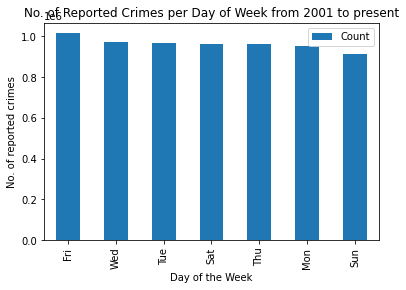

In [105]:
cp.sort_values('Count', ascending=False).plot(kind='bar', x='day_of_week', y='Count')
plt.xlabel('Day of the Week')
plt.ylabel('No. of reported crimes')
plt.title('No. of Reported Crimes per Day of Week from 2001 to present')

The plot also shows that **Friday** has the most number of reported crimes.

#**RDD - Resilient Distributed Datasets**

In [106]:
!ls

police_station.csv   sample_data		spark-2.3.1-bin-hadoop2.7.tgz
reported_crimes.csv  spark-2.3.1-bin-hadoop2.7	spark-warehouse


##**RDDs setup**

In [107]:
psrdd = sc.textFile('police_station.csv')
psrdd.first()

'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION'

In [108]:
ps_header = psrdd.first()

In [109]:
ps_rest = psrdd.filter(lambda line: line!= ps_header)
ps_rest.first()

'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

**How many Police Stations are there?**

In [110]:
ps_rest.map(lambda line: line.split(',')).collect()

[['Headquarters',
  'Headquarters',
  '3510 S Michigan Ave',
  'Chicago',
  'IL',
  '60653',
  'http://home.chicagopolice.org',
  '',
  '',
  '',
  '1177731.401',
  '1881697.404',
  '41.83070169',
  '-87.62339535',
  '"(41.8307016873',
  ' -87.6233953459)"'],
 ['18',
  'Near North',
  '1160 N Larrabee St',
  'Chicago',
  'IL',
  '60610',
  'http://home.chicagopolice.org/community/districts/18th-district-near-north/',
  '312-742-5870',
  '312-742-5771',
  '312-742-5773',
  '1172080.029',
  '1908086.527',
  '41.90324165',
  '-87.64335214',
  '"(41.9032416531',
  ' -87.6433521393)"'],
 ['19',
  'Town Hall',
  '850 W Addison St',
  'Chicago',
  'IL',
  '60613',
  'http://home.chicagopolice.org/community/districts/19th-district-town-hall/',
  '312-744-8320',
  '312-744-4481',
  '312-744-8011',
  '1169730.744',
  '1924160.317',
  '41.94740046',
  '-87.65151202',
  '"(41.9474004564',
  ' -87.651512018)"'],
 ['20',
  'Lincoln',
  '5400 N Lincoln Ave',
  'Chicago',
  'IL',
  '60625',
  'http://

In [111]:
ps_rest.map(lambda line: line.split(',')).count()

24

Hence, there are **24 police stations.**

**Display the District ID, District Name, Address and Zip for the police station with District ID 7**

In [117]:
(ps_rest.filter(lambda line: line.split(',')[0] == '7').
map(lambda line: (line.split(',')[0], 
                  line.split(',')[1],
                  line.split(',')[2],
                  line.split(',')[5])).collect())

[('7', 'Englewood', '1438 W 63rd St', '60636')]

**Police stations 10 and 11 are geographically close to each other. Display the District ID, District Name, address and zip code**

In [120]:
(ps_rest.filter(lambda line: line.split(',')[0] in ['10','11']).
map(lambda line: (line.split(',')[0],
                  line.split(',')[1],
                  line.split(',')[2],
                  line.split(',')[5])).collect())

[('10', 'Ogden', '3315 W Ogden Ave', '60623'),
 ('11', 'Harrison', '3151 W Harrison St', '60612')]